In [1]:
# Core Python & Utilities
from itertools import product
from tqdm import tqdm

# Data Handling
import numpy as np
import pandas as pd

# Stats & Modeling
import math
from scipy.optimize import curve_fit
from scipy.stats import sem, t

# Data Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Preferences
pd.set_option("display.max_columns", None)

# Basic Demo of How it Works

In [2]:
# ------------------------------------------------------------------------------------
# MPR Equation 1: Arousal
# A_t = a * r   (original form)
# Recursive update (running average over time):
# A_t = α * r_t + (1 - α) * A_{t-1}
# where:
#   A_t is arousal at time t
#   a is specific activation (strength of reinforcer)
#   r_t is rate of reinforcement at time t (either 0 or 1)
#   α is the learning rate / smoothing factor (0 < α < 1)
# ------------------------------------------------------------------------------------
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    """Update arousal based on previous value and new reinforcement event"""
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

# ------------------------------------------------------------------------------------
# MPR Equation 2b: Response Constraint
# b_total = (1 / δ) * (A / (1 + A))
# where:
#   b_total is the total rate of behavior (target + competing responses)
#   δ is the duration of a response
#   A is current arousal
# ------------------------------------------------------------------------------------
def compute_total_response_rate(A: float, delta: float) -> float:
    """Compute total response rate given arousal and motor constraint"""
    return (1 / delta) * (A / (1 + A))

# ------------------------------------------------------------------------------------
# MPR Equation 7: Direction/Coupling
# b_target = C * (1 / δ) * (A / (1 + A))
# where:
#   b_target is the rate of the target response (e.g., lever press)
#   C is the coupling coefficient, representing directional control (0 to 1)
# ------------------------------------------------------------------------------------
def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    """Compute target response rate based on arousal and coupling"""
    return coupling * (1 / delta) * (A / (1 + A))


# ------------------------------------------------------------------------------------
# Coupling update (based on schedule-sensitive asymptote):
# 
# C_t = C_{t-1} + η * (C* - C_{t-1})
#
# Where:
#   - η    : coupling learning rate (0 < η < 1)
#   - C*   : asymptotic coupling value based on schedule type and parameters
#
# C* is computed differently depending on the reinforcement schedule:
#   - FR:    C* = 1 - exp(-λ * n)                     (n = fixed ratio value)
#   - VR:    C* = 1 - exp(-λ * E[n])                  (E[n] = expected ratio)
#   - FI:    C* = ρ * (r / (r + k))                   (r = reinforcement rate)
#   - VI:    C* = ρ * (r / (r + k)) * ε               (ε < 1 dampens coupling)
#
# This reflects the idea that coupling depends not only on reinforcement occurrence,
# but on the organism's ability to detect contingency in the schedule structure.
# ------------------------------------------------------------------------------------
def compute_c_star(schedule_type: str,schedule_param: float, reinforcement_rate: float, lambda_: float = 0.3,
                   rho: float = 0.6, k: float = 1.0,epsilon: float = 0.8) -> float:
    """
    Compute schedule-sensitive asymptotic coupling value (C*) based on schedule type.
    """
    if schedule_type == 'FR':
        # schedule_param is the fixed ratio value (e.g., 10)
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'VR':
        # schedule_param is expected ratio (mean of the distribution)
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'FI':
        # reinforcement_rate: reinforcers per unit time
        return rho * (reinforcement_rate / (reinforcement_rate + k))
    elif schedule_type == 'VI':
        return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float = 0.05) -> float:
    """
    Update coupling coefficient based on schedule-sensitive asymptote.
    """
    return prev_coupling + learning_rate * (c_star - prev_coupling)

# def update_coupling(prev_coupling: float, was_reinforced: bool, learning_rate: float = 0.05, proximity: float = 1.0) -> float:
#     """Update coupling coefficient based on reinforcement outcome"""
#     target = proximity if was_reinforced else 0.1
#     return prev_coupling + learning_rate * (target - prev_coupling)


# ------------------------------------------------------------------------------------
# Wrapper for a single update step in the MPR simulation.
#
# This function updates:
#   - Arousal (A), based on recent reinforcement and learning rate α
#   - Coupling (C), using a recursive update toward a schedule-sensitive asymptote C*
#   - Total response rate (b_total), based on motor constraint and arousal
#   - Target response rate (b_target), incorporating both arousal and coupling
#
# Inputs:
#   prev_arousal         : float    - Arousal level at previous time step
#   prev_coupling        : float    - Coupling strength at previous time step
#   reinforcement        : int      - Reinforcement received at current step (0 or 1)
#   a                    : float    - Specific activation (reinforcer magnitude)
#   delta                : float    - Duration of a response (motor constraint)
#   alpha                : float    - Learning rate for arousal (default: 0.1)
#   eta                  : float    - Learning rate for coupling (default: 0.05)
#   schedule_type        : str      - One of 'FR', 'VR', 'FI', 'VI'
#   schedule_param       : float    - Schedule parameter (e.g., FR value, VI mean)
#   reinforcement_rate   : float    - Moving average of reinforcement per unit time
#   lambda_              : float    - Steepness of coupling growth (FR/VR)
#   rho                  : float    - Temporal coupling strength (FI/VI)
#   k                    : float    - Decoupling constant (FI/VI)
#   epsilon              : float    - Dampening factor for VI (uncertainty)
#
# Outputs:
#   A                    : float    - Updated arousal
#   C                    : float    - Updated coupling
#   b_total              : float    - Total response rate
#   b_target             : float    - Target response rate
# ------------------------------------------------------------------------------------
def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha=0.1, eta=0.05,
                schedule_type='VR', schedule_param=10, reinforcement_rate=1.0, lambda_=0.3,
                rho=0.6, k=1.0, epsilon=0.8):
    """
    Run one update of arousal, coupling, and response rates.
    Coupling updates toward a schedule-sensitive asymptote C*.
    """
    # Update arousal
    A = update_arousal(prev_arousal, reinforcement, alpha, a)

    # Compute coupling asymptote C* based on schedule
    C_star = compute_c_star(
        schedule_type=schedule_type,
        schedule_param=schedule_param,
        reinforcement_rate=reinforcement_rate,
        lambda_=lambda_,
        rho=rho,
        k=k,
        epsilon=epsilon
    )

    # Update coupling toward C*
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)

    # Compute response rates
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)

    return A, C, b_total, b_target

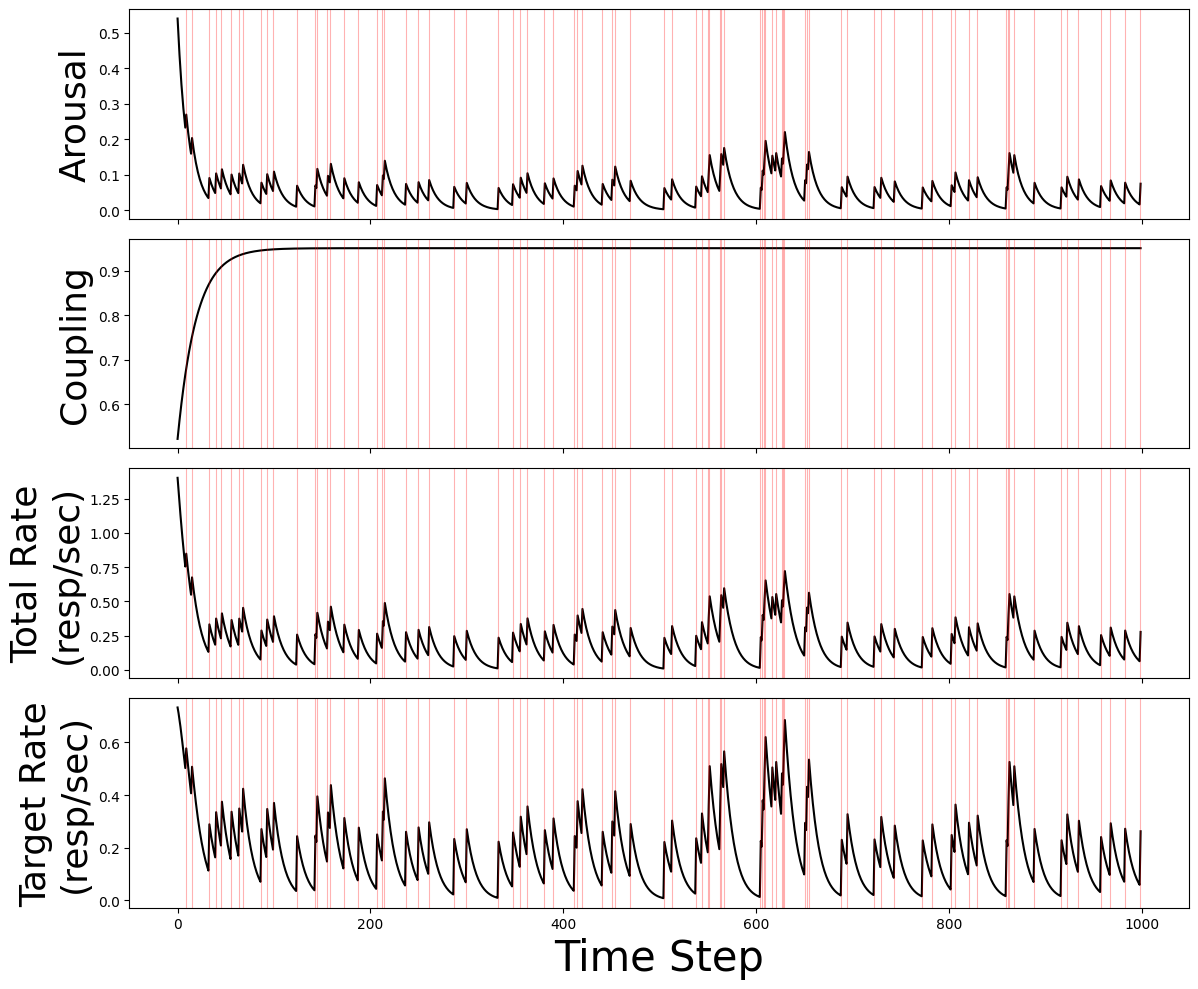

In [3]:
# Parameters
num_steps = 1000
delta = 0.25
a = 0.6
alpha = 0.1
eta = 0.05
schedule_type = 'VR'
schedule_param = 10  # VR-10

# Constants for coupling dynamics
lambda_ = 0.3
rho = 0.6
k = 1.0
epsilon = 0.8
reinforcement_window = 50  # for moving average

# Initialize state
A = 0.6
C = 0.5
arousal_history = []
coupling_history = []
b_total_history = []
b_target_history = []
reinforcement_history = []
reinforced_times = []

# Simulation loop
for time_step in range(num_steps):
    # Simulate reinforcement (VR)
    reinforcement = np.random.rand() < (1 / schedule_param)
    reinforcement_history.append(reinforcement)
    if reinforcement:
        reinforced_times.append(time_step)

    # Compute reinforcement rate (moving average)
    recent = reinforcement_history[-reinforcement_window:]
    reinforcement_rate = sum(recent) / reinforcement_window

    # Update model
    A, C, b_total, b_target = update_step(
        prev_arousal=A,
        prev_coupling=C,
        reinforcement=reinforcement,
        a=a,
        delta=delta,
        alpha=alpha,
        eta=eta,
        schedule_type=schedule_type,
        schedule_param=schedule_param,
        reinforcement_rate=reinforcement_rate,
        lambda_=lambda_,
        rho=rho,
        k=k,
        epsilon=epsilon
    )

    # Record values
    arousal_history.append(A)
    coupling_history.append(C)
    b_total_history.append(b_total)
    b_target_history.append(b_target)

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

def add_reinforcement_lines(ax):
    for rt in reinforced_times:
        ax.axvline(x=rt - 0.5, color='red', alpha=0.3, linewidth=0.8)

axs[0].plot(arousal_history, color='k', label="Arousal (A)")
add_reinforcement_lines(axs[0])
axs[0].set_ylabel("Arousal", fontsize=26)
# axs[0].legend(fontsize=14)

axs[1].plot(coupling_history, color='k', label="Coupling (C)")
add_reinforcement_lines(axs[1])
axs[1].set_ylabel("Coupling", fontsize=26)
# axs[1].legend(fontsize=14)

axs[2].plot(b_total_history, color='k', label="Total Response Rate")
add_reinforcement_lines(axs[2])
axs[2].set_ylabel("Total Rate\n(resp/sec)", fontsize=26)
# axs[2].legend(fontsize=14)

axs[3].plot(b_target_history, color='k', label="Target Response Rate")
add_reinforcement_lines(axs[3])
axs[3].set_ylabel("Target Rate\n(resp/sec)", fontsize=26)
# axs[3].legend(fontsize=14)
axs[3].set_xlabel("Time Step", fontsize=30)

plt.tight_layout()
plt.show()


# A Range of Single VR Schedule

In [4]:
# --- Confidence Interval ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Main Simulation Function ---
def simulate_mpr_sequence(vr_schedule_list, a, delta, alpha, eta, ao_id, steps_per_schedule=1000,
                          lambda_=0.3, rho=0.6, k=1.0, epsilon=0.8):
    
    # Starting arousal and coupling parameters
    A, C = 0.6, 0.5
    all_results = []

    for vr_idx, vr in enumerate(vr_schedule_list):
        A_hist, C_hist, bt_hist, bp_hist = [], [], [], []
        reinforcement_history = []

        for step in range(steps_per_schedule):
            reinforcement = np.random.rand() < (1 / vr)
            reinforcement_history.append(reinforcement)

            # Use recent reinforcement rate (sliding window of 50 steps)
            window = 50
            recent = reinforcement_history[-window:]
            reinforcement_rate = sum(recent) / window

            # Run update step with schedule-aware coupling
            A, C, b_total, b_target = update_step(
                prev_arousal=A,
                prev_coupling=C,
                reinforcement=reinforcement,
                a=a,
                delta=delta,
                alpha=alpha,
                eta=eta,
                schedule_type='VR',
                schedule_param=vr,
                reinforcement_rate=reinforcement_rate,
                lambda_=lambda_,
                rho=rho,
                k=k,
                epsilon=epsilon
            )

            A_hist.append(A)
            C_hist.append(C)
            bt_hist.append(b_total)
            bp_hist.append(b_target)

        all_results.append({
            'AO_id': ao_id,
            'vr_sequence_index': vr_idx,
            'VR': vr,
            'arousal_avg': np.mean(A_hist),
            'arousal_min': np.min(A_hist),
            'arousal_max': np.max(A_hist),
            'arousal_ci': ci95(A_hist),
            'coupling_avg': np.mean(C_hist),
            'coupling_min': np.min(C_hist),
            'coupling_max': np.max(C_hist),
            'coupling_ci': ci95(C_hist),
            'b_total_avg': np.mean(bt_hist),
            'b_total_min': np.min(bt_hist),
            'b_total_max': np.max(bt_hist),
            'b_total_ci': ci95(bt_hist),
            'b_target_avg': np.mean(bp_hist),
            'b_target_min': np.min(bp_hist),
            'b_target_max': np.max(bp_hist),
            'b_target_ci': ci95(bp_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
        })

    return all_results


# --- Parameter Grid ---
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vr_schedules = [1, 3, 10, 30, 100, 300, 1000]

# --- Grid Search Over AO Parameter Combinations ---
results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running simulations per AO")):
    shuffled_vrs = np.random.permutation(vr_schedules)
    sim_result_list = simulate_mpr_sequence(
        vr_schedule_list=shuffled_vrs,
        a=a,
        delta=delta,
        alpha=alpha,
        eta=eta,
        ao_id=ao_id
    )
    results.extend(sim_result_list)

# --- Final Results DataFrame ---
results_df = pd.DataFrame(results)

# View Output
results_df

Running simulations per AO: 100%|██████████| 400/400 [01:11<00:00,  5.61it/s]


,AO_id,vr_sequence_index,VR,arousal_avg,arousal_min,arousal_max,arousal_ci,coupling_avg,coupling_min,coupling_max,coupling_ci,b_total_avg,b_total_min,b_total_max,b_total_ci,b_target_avg,b_target_min,b_target_max,b_target_ci,activation,delta,alpha,eta
0,0,0,1000,0.059497,0.000029,0.594000,0.007396,0.950502,0.505000,0.999978,6.165828e-03,0.186696,0.000116,1.490590,0.021080,0.143953,0.000116,0.778391,0.014428,0.1,0.25,0.01,0.01
1,0,1,10,0.009890,0.000028,0.015055,0.000154,0.955140,0.950215,0.999481,6.136908e-04,0.039148,0.000114,0.059328,0.000606,0.037336,0.000114,0.056427,0.000573,0.1,0.25,0.01,0.01
2,0,2,1,0.090713,0.007131,0.099996,0.001157,0.327591,0.259212,0.943305,8.521585e-03,0.331556,0.028321,0.363623,0.004071,0.099617,0.026716,0.126224,0.000747,0.1,0.25,0.01,0.01
3,0,3,3,0.040391,0.025115,0.099006,0.000880,0.560344,0.262554,0.593416,4.121470e-03,0.154599,0.097999,0.360348,0.003151,0.083354,0.058087,0.116263,0.000740,0.1,0.25,0.01,0.01
4,0,4,30,0.006246,0.001357,0.035090,0.000405,0.959639,0.597481,0.999859,5.012333e-03,0.024665,0.005421,0.135603,0.001575,0.021646,0.005418,0.082294,0.001095,0.1,0.25,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,399,2,3,0.534400,0.000000,1.600000,0.046851,0.593430,0.593430,0.593430,0.000000e+00,0.102769,0.000000,0.307692,0.009010,0.060986,0.000000,0.182594,0.005347,1.6,2.00,1.00,1.00
2796,399,3,30,0.051200,0.000000,1.600000,0.017483,0.999877,0.999877,0.999877,1.378580e-17,0.009846,0.000000,0.307692,0.003362,0.009845,0.000000,0.307654,0.003362,1.6,2.00,1.00,1.00
2797,399,4,1000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.6,2.00,1.00,1.00
2798,399,5,100,0.017600,0.000000,1.600000,0.010361,1.000000,1.000000,1.000000,1.378580e-17,0.003385,0.000000,0.307692,0.001993,0.003385,0.000000,0.307692,0.001993,1.6,2.00,1.00,1.00


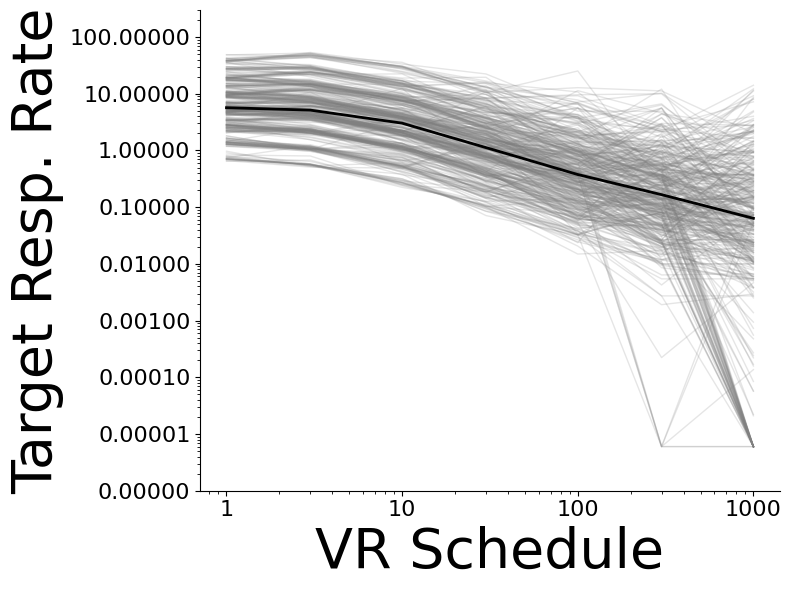

In [5]:
# Sort the data so each AO's line is plotted in VR sequence order
results_df_sorted = results_df.sort_values(['AO_id', 'VR'])
results_df_sorted['b_target_avg'] = results_df_sorted['b_target_avg'].clip(lower=0.0000001)
results_df_sorted['b_target_avg'] = results_df_sorted['b_target_avg']*60

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each AO's line
for _, ao_data in results_df_sorted.groupby("AO_id"):
    ax.plot(
        ao_data['VR'],
        ao_data['b_target_avg'],
        color='gray',
        alpha=0.2,
        linewidth=1
    )

# Overlay a central tendency
avg_data = results_df_sorted.groupby('VR')['b_target_avg'].median().reset_index()
sns.lineplot(
    data=avg_data,
    x='VR', y='b_target_avg',
    color='black',
    linewidth=2,
    label='Mean across AOs'
)

# Log scales for both axes
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(0.000001, 300)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# Labels and style
ax.set_ylabel("Target Resp. Rate", fontsize=40)
ax.set_xlabel("VR Schedule", fontsize=40)
ax.legend().remove()
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

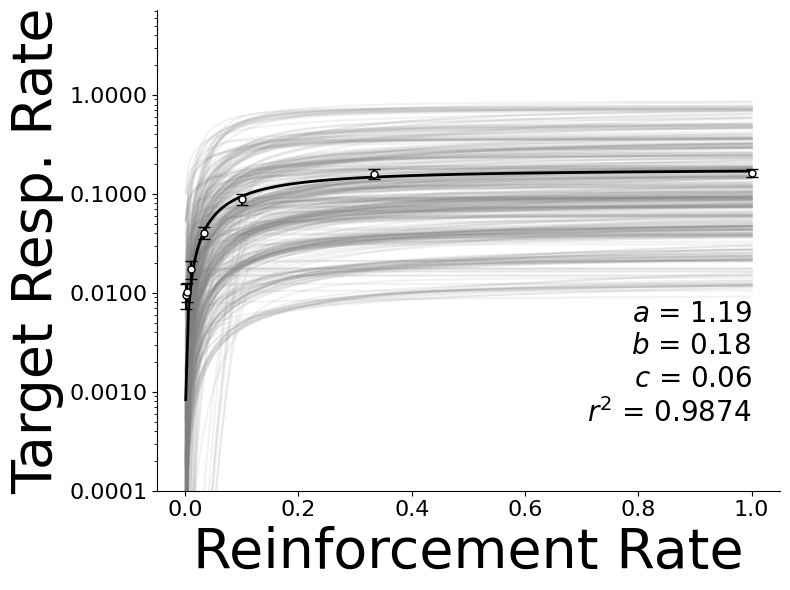

In [6]:
# Compute reinforcement rate
results_df['r'] = 1 / results_df['VR']
results_df['b_target_avg'] = results_df['b_target_avg']

# Define generalized hyperbola
def generalized_hyperbola(r, a, b, c):
    return (b * (r ** a)) / (r ** a + c)

# Fit function per AO
def fit_ao_hyperbola(df):
    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            df['r'],
            df['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )
        return popt
    except:
        return [np.nan, np.nan, np.nan]

# Fit and store per-AO curves
fit_results = []
ao_curves = []

# Loop over AOs
for ao_id, group in results_df.groupby("AO_id"):
    try:
        # Fit hyperbola
        popt, _ = curve_fit(
            generalized_hyperbola,
            group['r'],
            group['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )

        # Predict using the fit
        predicted = generalized_hyperbola(group['r'], *popt)

        # Compute R²
        residuals = group['b_target_avg'] - predicted
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((group['b_target_avg'] - np.mean(group['b_target_avg'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Store parameters and R²
        fit_results.append({
            'AO_id': ao_id,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

        # Store predicted curve
        r_vals = np.linspace(group['r'].min(), group['r'].max(), 200)
        predicted_curve = generalized_hyperbola(r_vals, *popt)
        ao_curves.append(pd.DataFrame({
            'AO_id': ao_id,
            'r': r_vals,
            'predicted_b_target': predicted_curve
        }))

    except:
        continue  # skip AOs that fail to fit

fit_df = pd.DataFrame(fit_results)
curves_df = pd.concat(ao_curves, ignore_index=True)

# Group-level mean and CI
grouped = results_df.groupby('r').agg(
    b_target_avg_mean=('b_target_avg', 'mean'),
    b_target_avg_se=('b_target_avg', sem)
).reset_index()
grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit group-level curve
popt, _ = curve_fit(
    generalized_hyperbola,
    grouped['r'],
    grouped['b_target_avg_mean'],
    p0=[1.0, 1.0, 0.1],
    bounds=(0, np.inf)
)
r_vals = np.linspace(grouped['r'].min(), grouped['r'].max(), 200)
group_fit = generalized_hyperbola(r_vals, *popt)

# R² calculation for group-level fit
residuals = grouped['b_target_avg_mean'] - generalized_hyperbola(grouped['r'], *popt)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((grouped['b_target_avg_mean'] - np.mean(grouped['b_target_avg_mean'])) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(8, 6))

# Plot all individual AO fits
for ao_id, ao_curve in curves_df.groupby("AO_id"):
    plt.plot(ao_curve['r'], ao_curve['predicted_b_target'], alpha=0.1, color='gray')

# Plot group-level fit
plt.plot(r_vals, group_fit, color='black', linewidth=2, label='Group Mean Fit')

# Overlay mean ± CI as white points with black outlines
plt.errorbar(
    grouped['r'],
    grouped['b_target_avg_mean'],
    yerr=grouped['b_target_avg_ci'],
    fmt='o',
    color='white',
    markersize=5,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Add annotation for group-level fit parameters
plt.text(
    x=1,
    y=0.0005,
    s=f"$a$ = {popt[0]:.2f}\n$b$ = {popt[1]:.2f}\n$c$ = {popt[2]:.2f}\n$r^2$ = {r_squared:.4f}",
    fontsize=20,
    ha='right'
)

# Style
plt.yscale("log")
plt.xlabel("Reinforcement Rate", fontsize=40)
plt.ylabel("Target Resp. Rate", fontsize=40)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.legend().remove()
plt.ylim(.0001, )
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

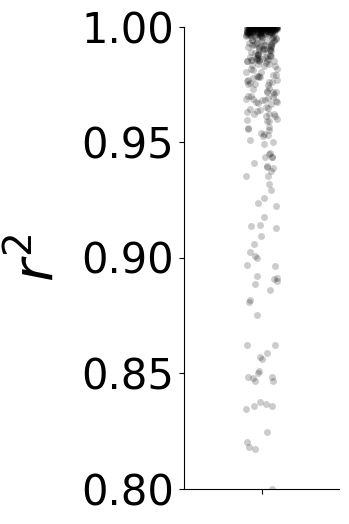

In [7]:
# Plot stripplot of R-squared values
fig, ax = plt.subplots(figsize=(2, 6))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.8, 0.85, 0.9, 0.95, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.ylim(0.8, 1)
plt.show()

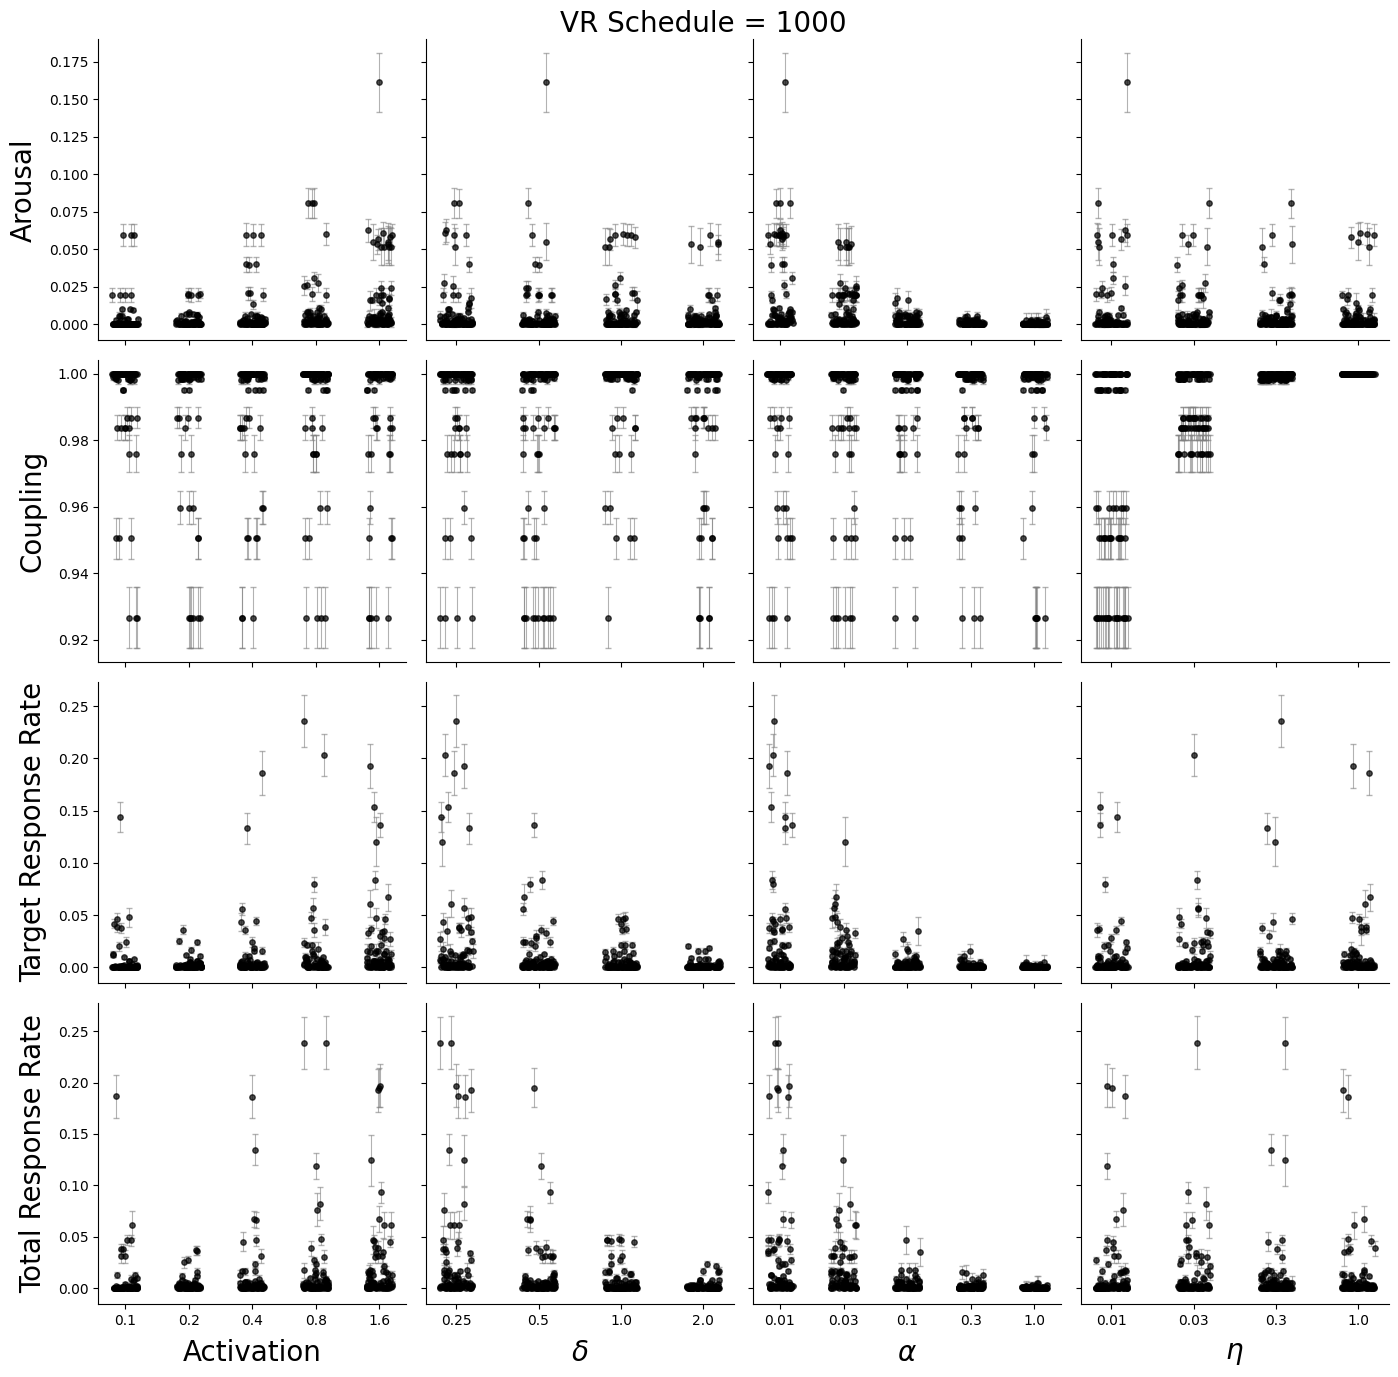

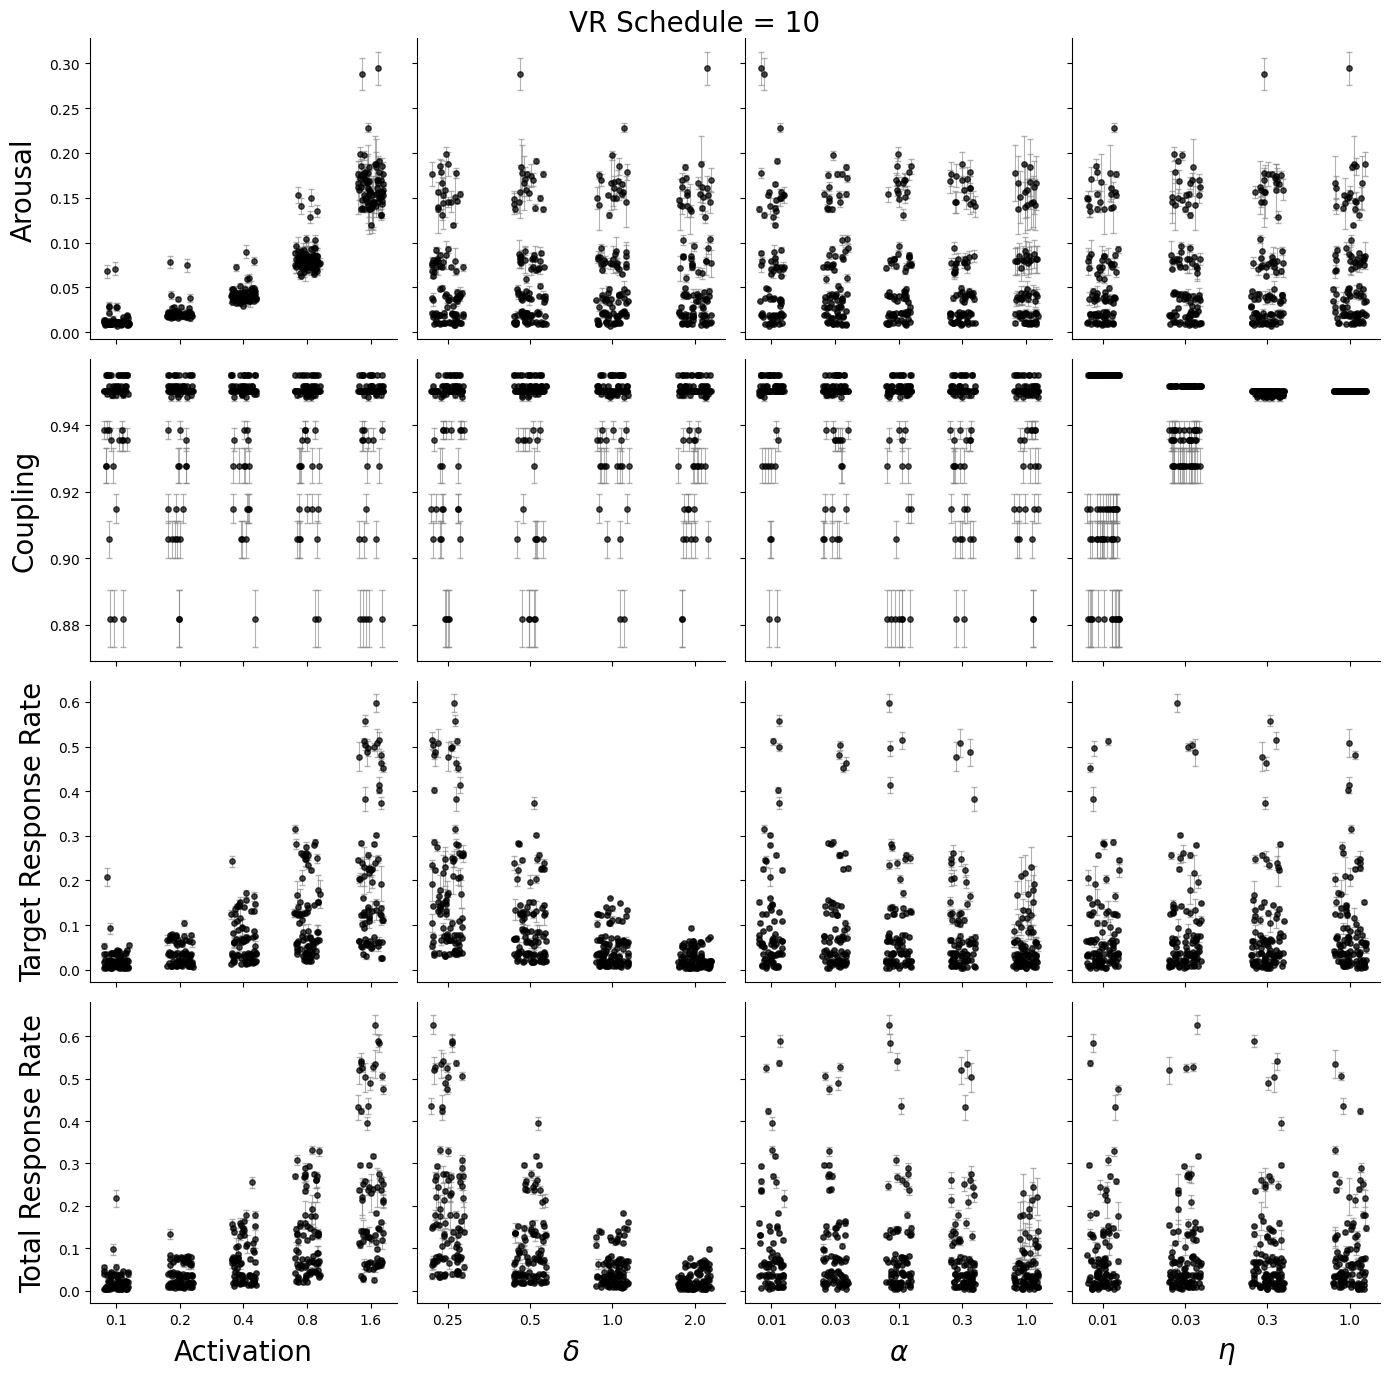

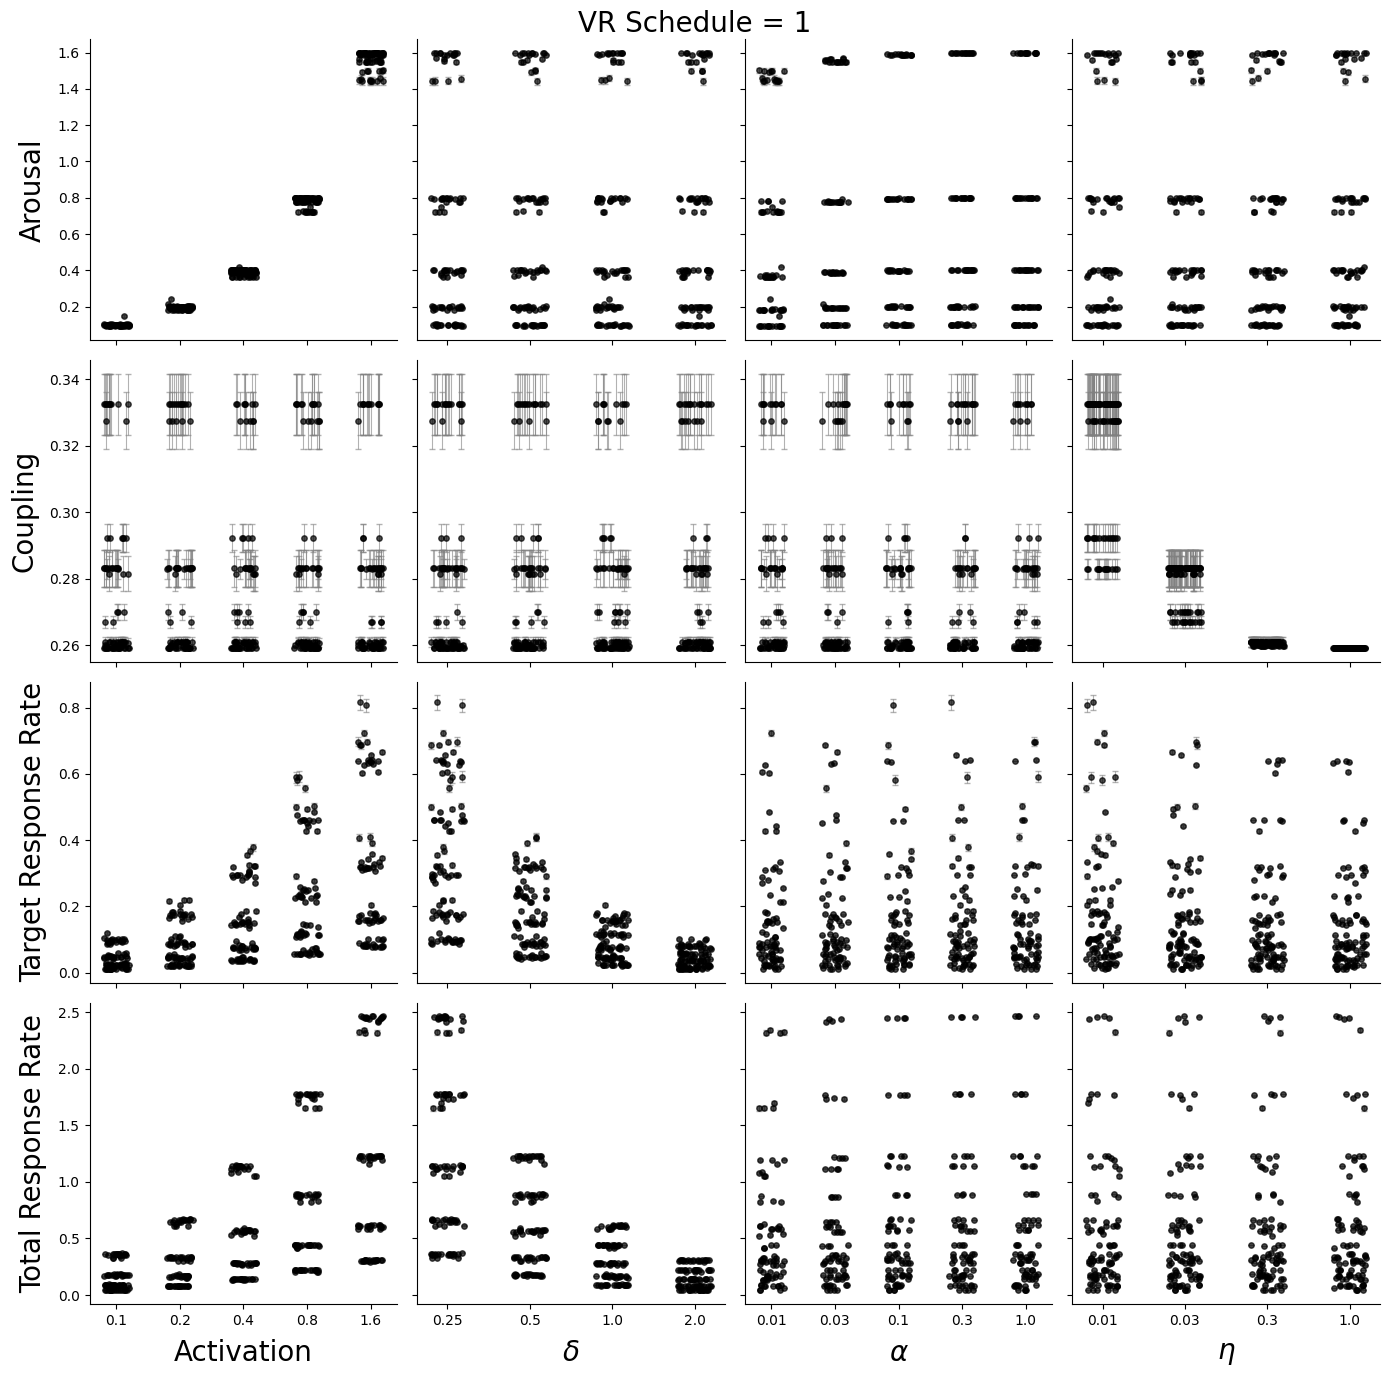

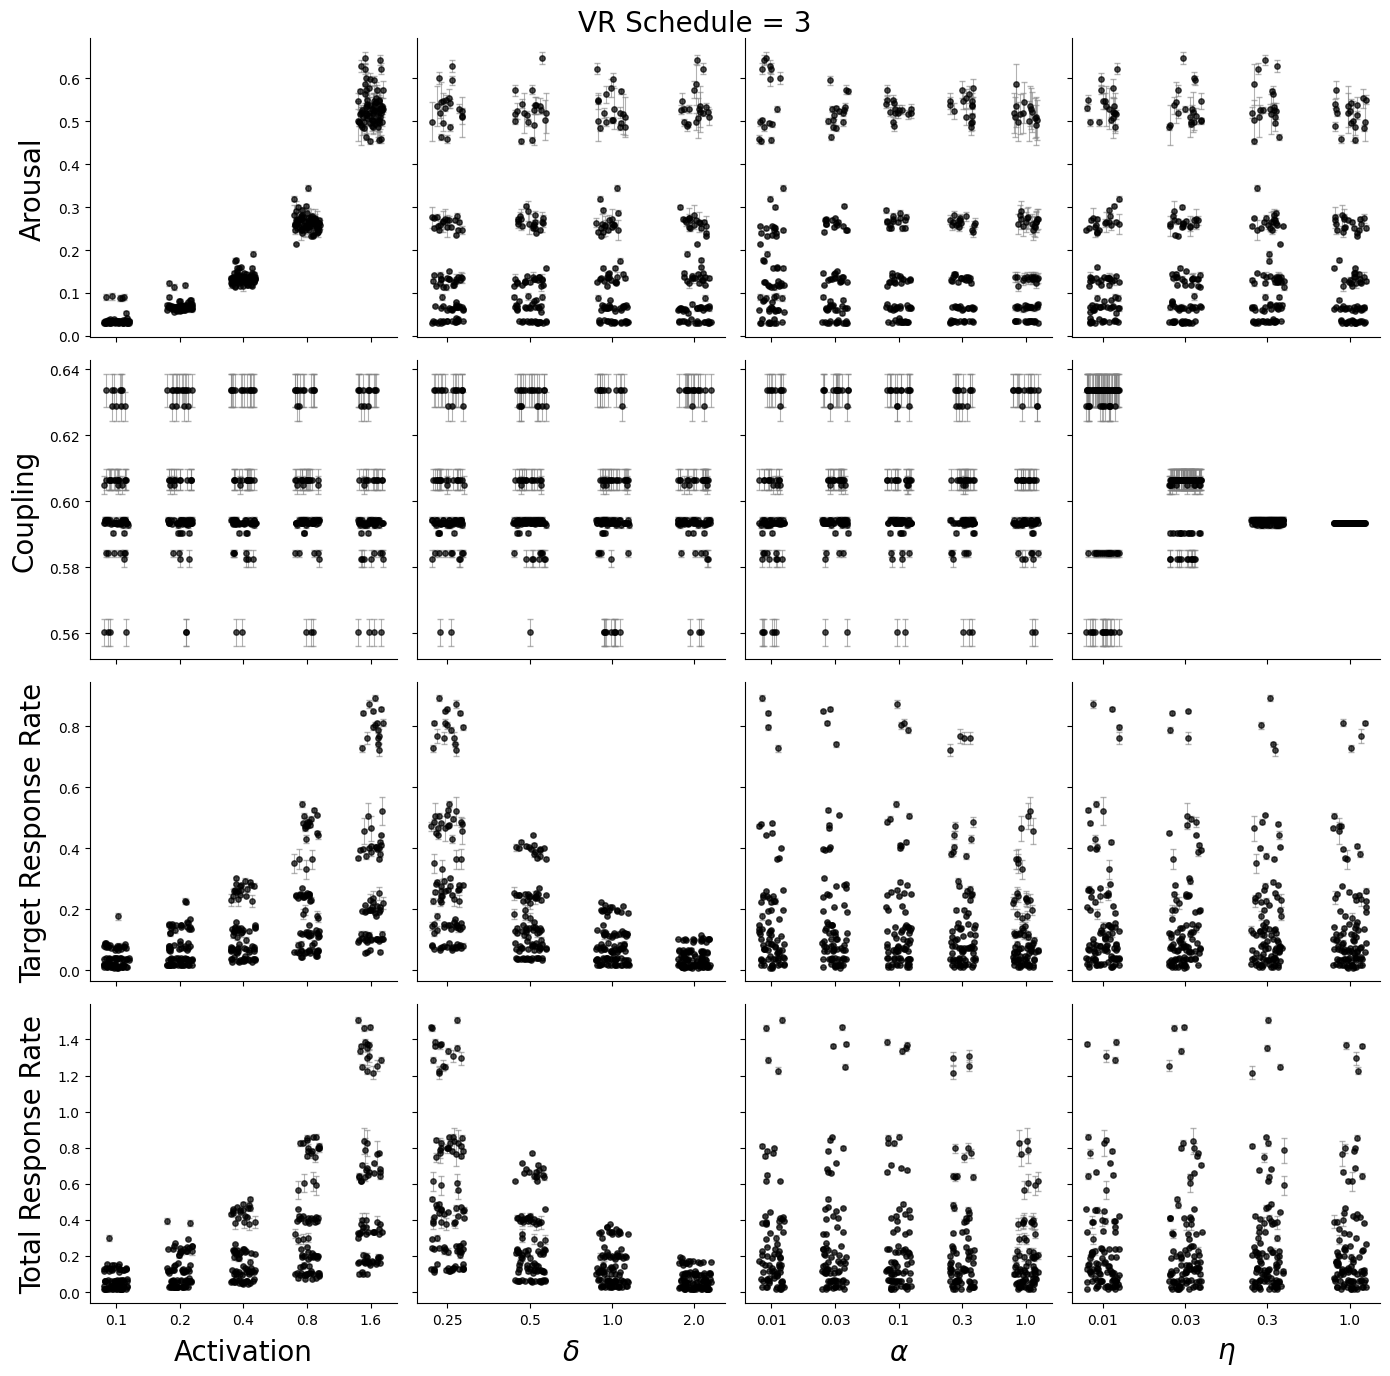

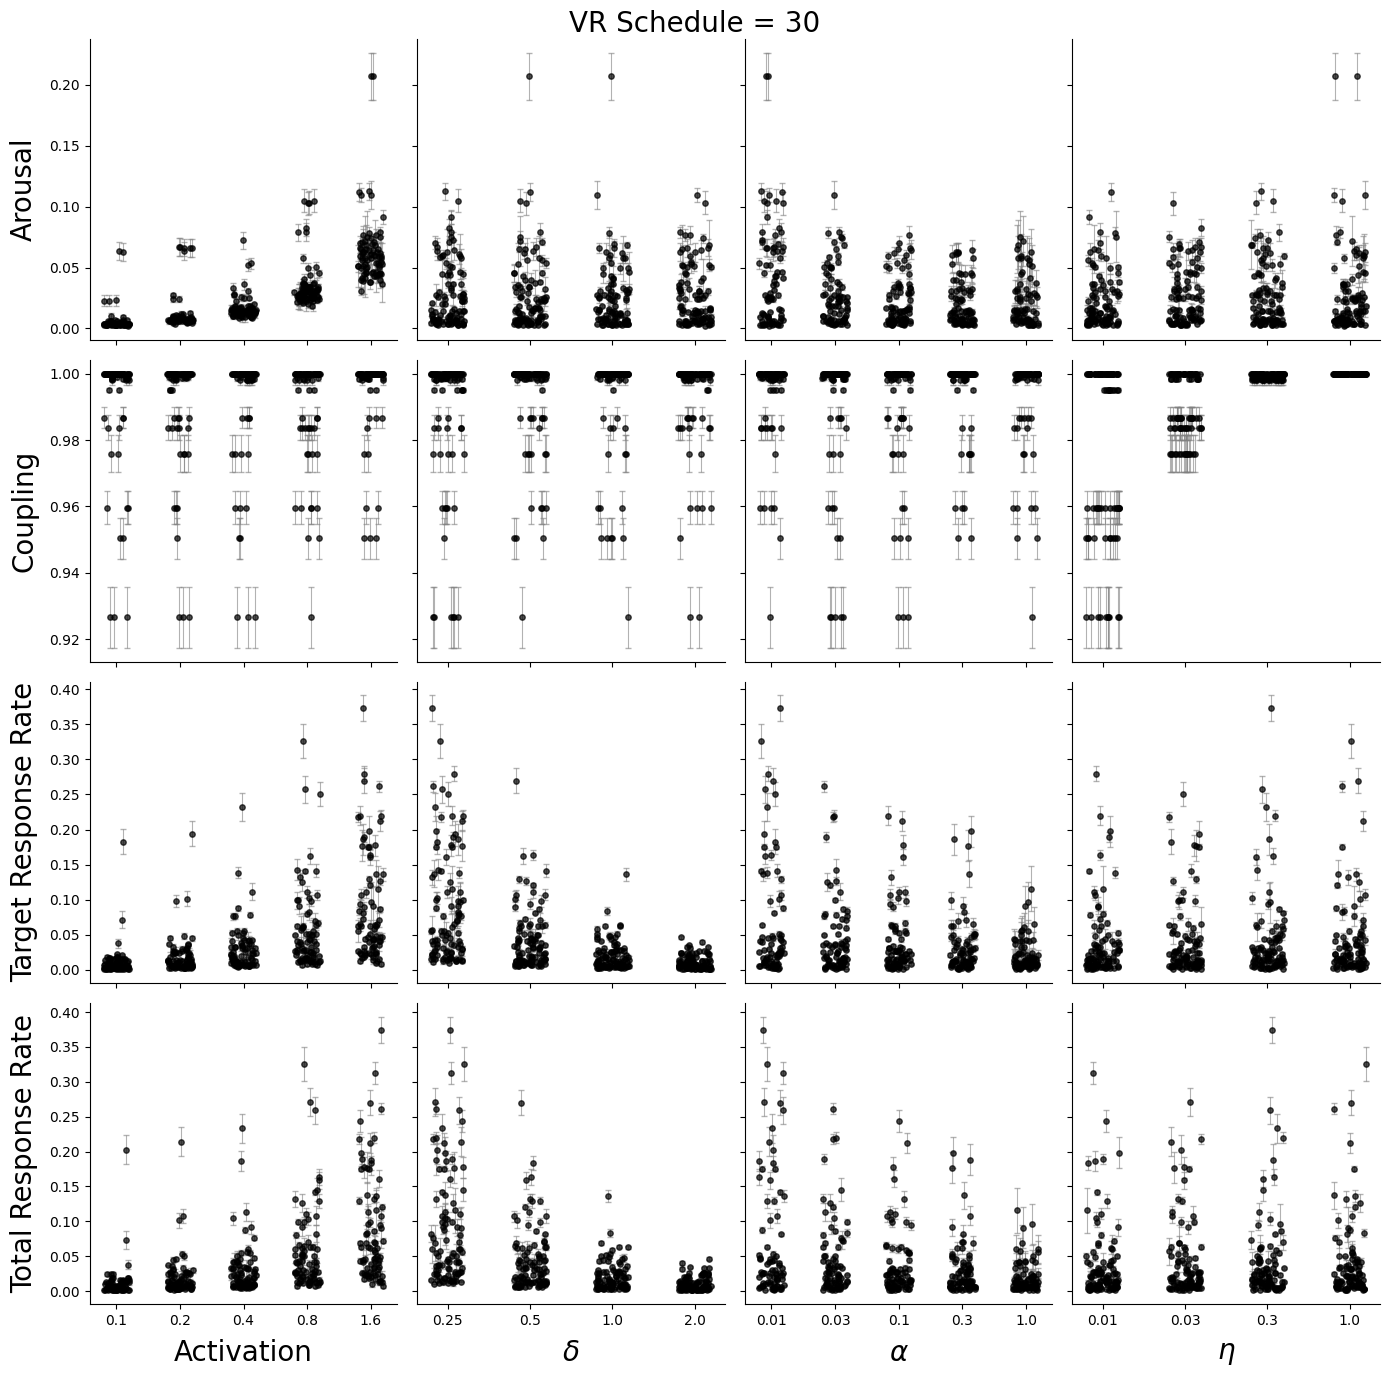

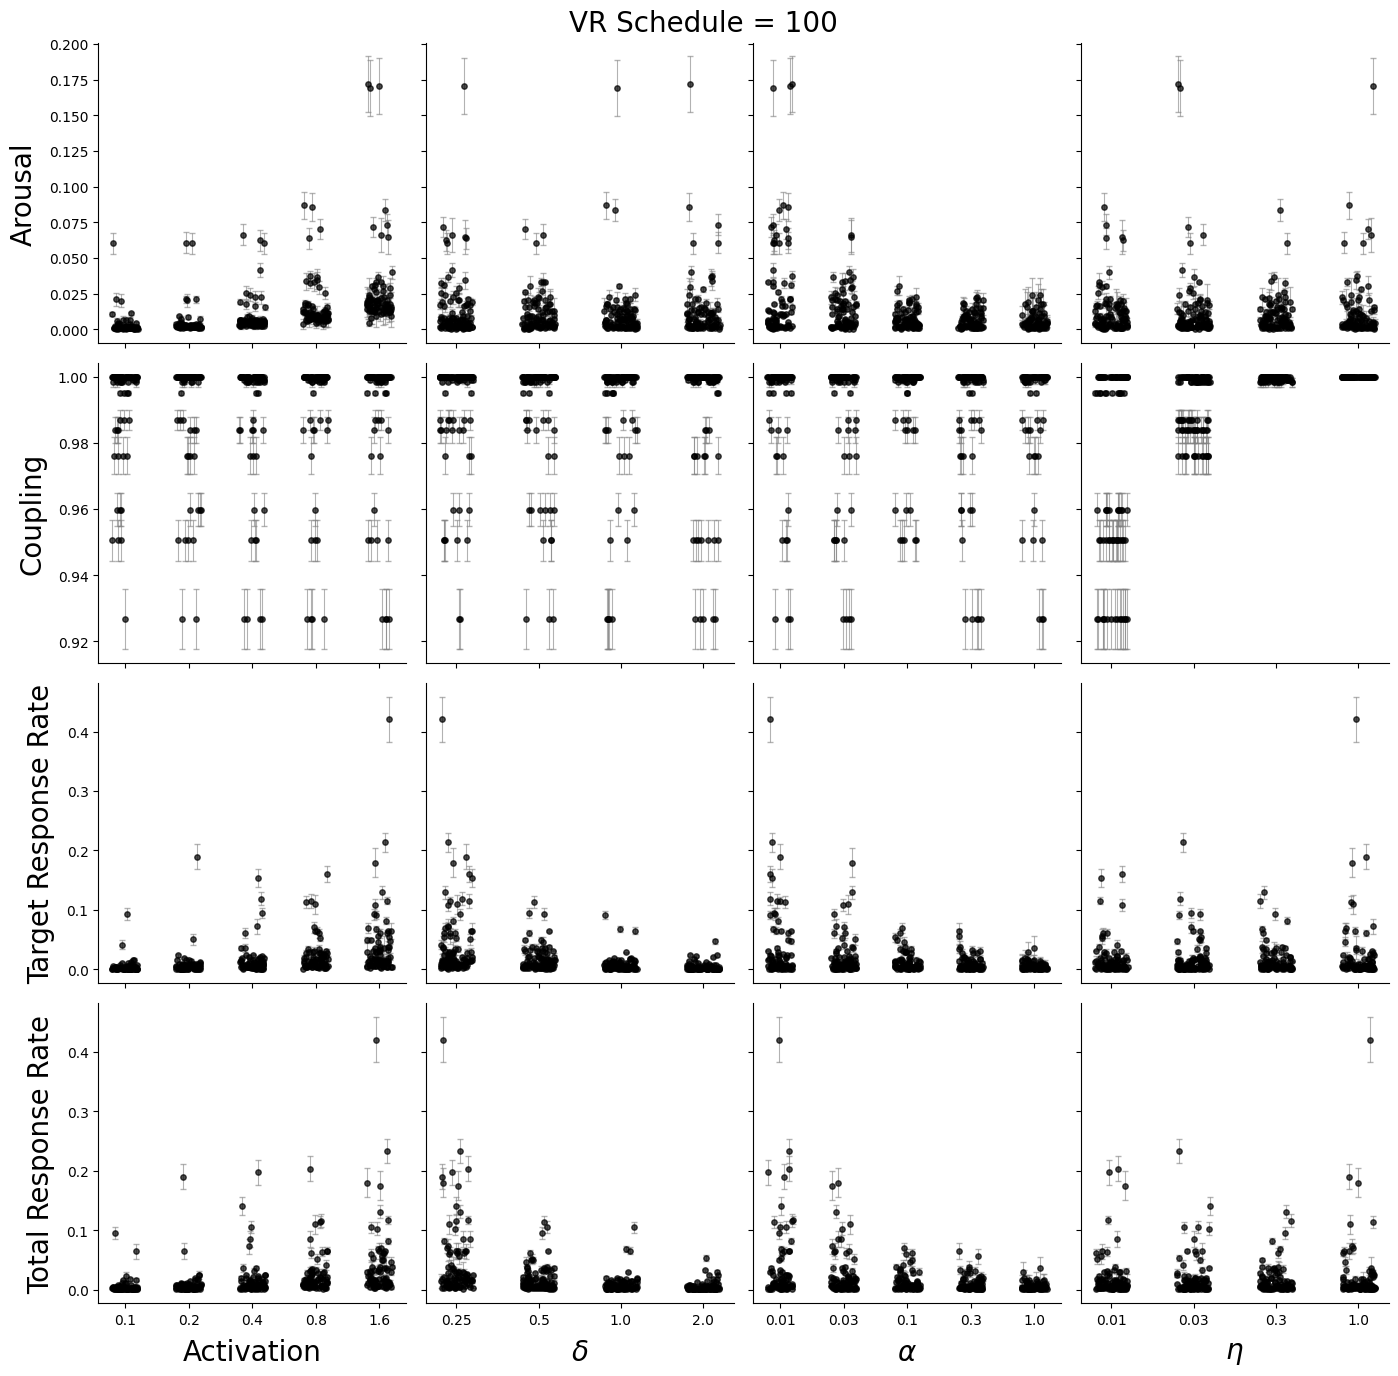

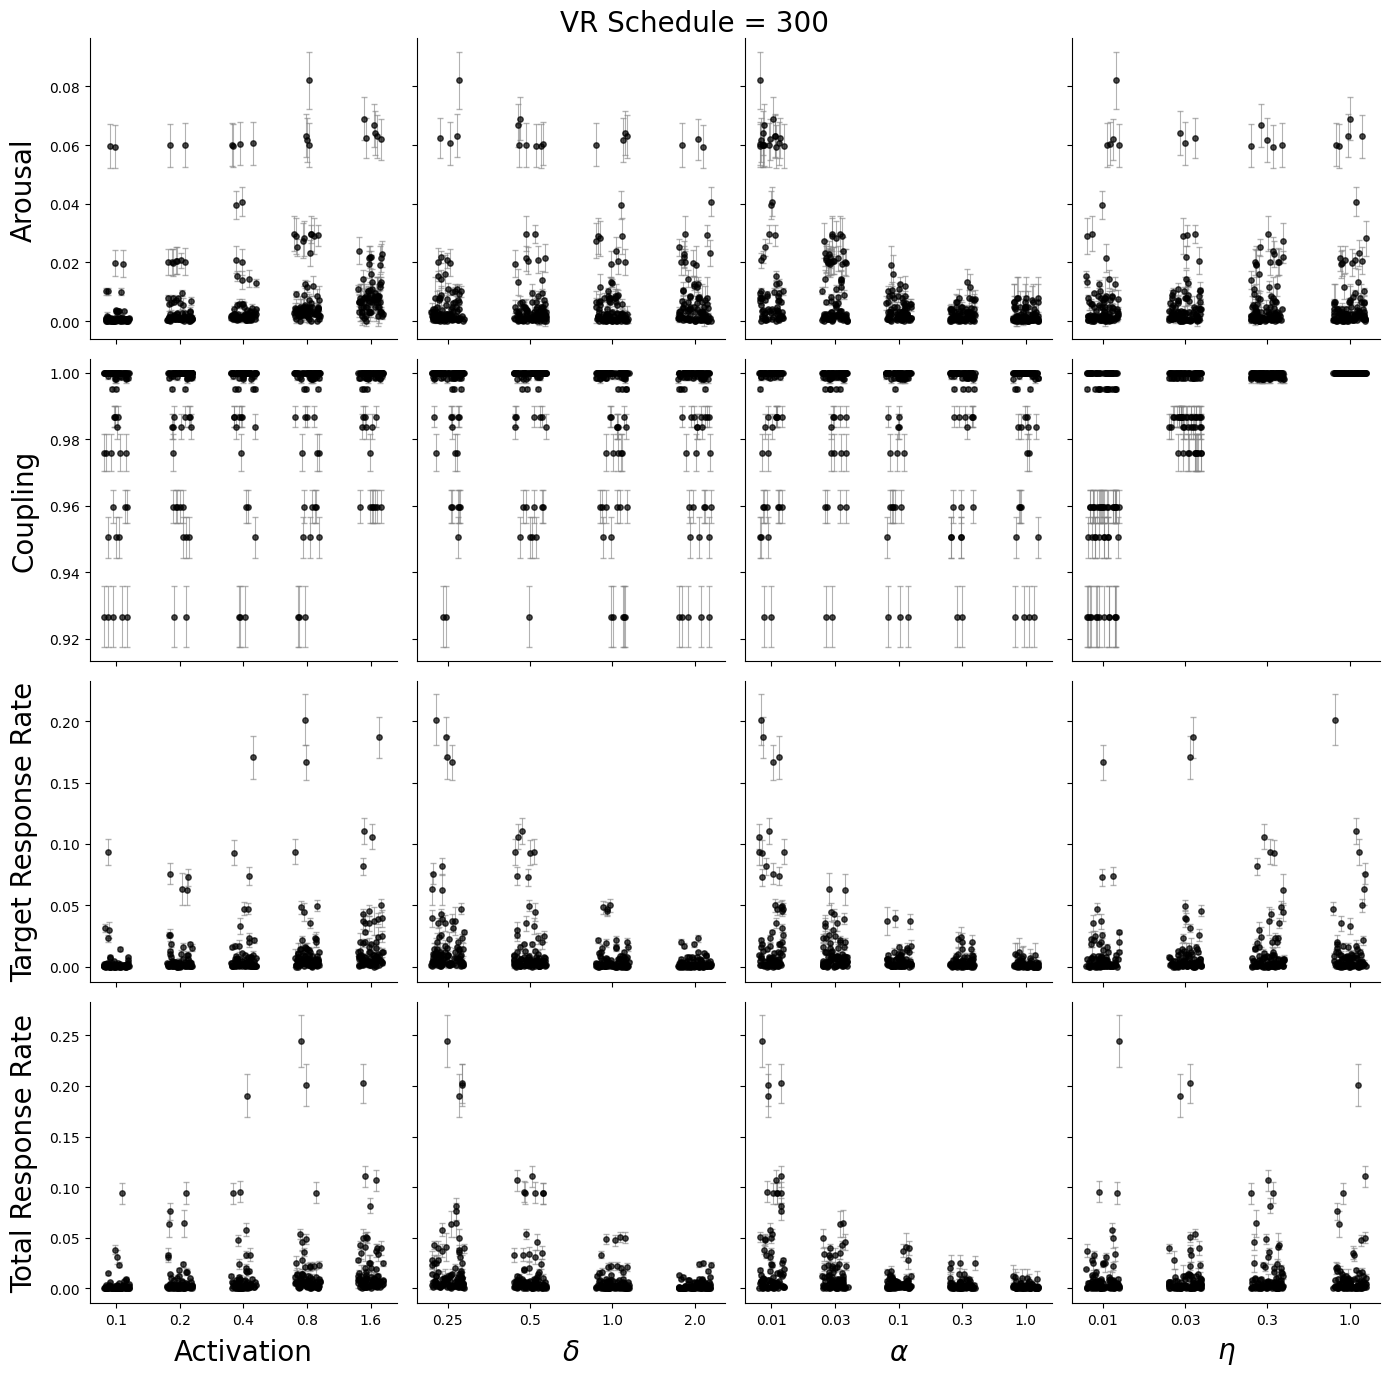

In [8]:
for vr_val in results_df['VR'].unique():
  df_vr = results_df[results_df['VR'] == vr_val]

  # Metric column mapping
  metrics = {
      'arousal_avg': ('Arousal', 'arousal_ci'),
      'coupling_avg': ('Coupling', 'coupling_ci'),
      'b_target_avg': ('Target Response Rate', 'b_target_ci'),
      'b_total_avg': ('Total Response Rate', 'b_total_ci')
  }

  params = ['activation', 'delta', 'alpha', 'eta']

  # Create 4x4 subplot grid
  fig, axs = plt.subplots(4, 4, figsize=(14, 14), sharex='col', sharey=False)
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  # Plot each metric × parameter
  for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics.items()):
      for col_idx, param in enumerate(params):
          ax = axs[row_idx, col_idx]

          # Get data for this combo
          sub_df = df_vr[[param, metric_col, ci_col]].copy()

          # Convert the x (param) to categorical codes for spacing
          sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
          x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

          # Plot strip manually
          ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)

          # Plot error bars (CIs)
          ax.errorbar(
              x_jittered,
              sub_df[metric_col],
              yerr=sub_df[ci_col],
              fmt='none',
              ecolor='gray',
              elinewidth=0.8,
              capsize=2,
              alpha=0.6,
              zorder=1
          )

          # Add symbolic labels
          param_symbols = {
              'activation': 'Activation',
              'delta': r'$\delta$',
              'alpha': r'$\alpha$',
              'eta': r'$\eta$'
          }

          # Format axes
          if row_idx == 3:
              ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
              ax.set_xticks(range(len(sub_df[param].unique())))
              ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
          else:
              ax.set_xlabel("")
              ax.set_xticklabels([])
              ax.tick_params(labelbottom=False)

          if col_idx == 0:
              ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
          else:
              ax.set_ylabel("")
              ax.set_yticklabels([])

          ax.grid(False)
          sns.despine(top=True, right=True)

  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.suptitle(f"VR Schedule = {vr_val}", fontsize=20)
  plt.show()
